# ReadDesignChain LLM Eval

In [1]:
%load_ext autoreload
%autoreload all

## Run the chain

In [16]:
from meche_copilot.schemas import *
from meche_copilot.chains.read_design_chain import ReadDesignChain
from meche_copilot.utils.config import load_config, find_config
from langchain.callbacks import StdOutCallbackHandler

In [17]:
config = SessionConfig.from_yaml(find_config('/workspaces/meche-copilot/session-config.yaml'))
sess = Session.from_config(config=config)

2023-08-13 17:55:33.677 | INFO     | meche_copilot.schemas:from_yaml:126 - Loading config from /workspaces/meche-copilot/session-config.yaml


2023-08-13 17:55:33.680 | DEBUG    | meche_copilot.schemas:file_must_exist:119 - Validating file path: data/demo-01
2023-08-13 17:55:33.680 | DEBUG    | meche_copilot.schemas:file_must_exist:119 - Validating file path: data/templates
2023-08-13 17:55:33.681 | DEBUG    | meche_copilot.schemas:file_must_exist:119 - Validating file path: data/demo-01/scope.xlsx
2023-08-13 17:55:33.681 | INFO     | meche_copilot.schemas:from_config:305 - Getting session info from config...
2023-08-13 17:55:33.682 | INFO     | meche_copilot.schemas:load_equipments_from_scope:388 - Getting scoped equipments...
/home/vscode/meche-copilot-py-env/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [18]:
chain = ReadDesignChain()
chain.design_data_cache

PosixPath('/workspaces/meche-copilot/data/.cache/design_data')

In [19]:
# SHOULD FAIL - NOT IMPLEMENTED
# chain.read_design_drawings(scoped_eq=sess.equipments)

In [20]:
# show your work so we can eval camelot plots and such
design_schedules = chain.read_design_schedules(scoped_eq=sess.equipments, show_your_work=True)

2023-08-13 17:55:34.476 | INFO     | meche_copilot.chains.read_design_chain:read_design_schedules:144 - Getting all schedules from design docs...
2023-08-13 17:55:34.477 | DEBUG    | meche_copilot.chains.read_design_chain:read_design_schedules:147 - Using cached file: /workspaces/meche-copilot/data/.cache/design_data/1_all_design_schedules.jsonl
2023-08-13 17:55:34.478 | DEBUG    | meche_copilot.chains.read_design_chain:read_design_schedules:156 - 50 schedule candidates in design docs
2023-08-13 17:55:34.479 | SUCCESS  | meche_copilot.chains.read_design_chain:read_design_schedules:160 - Done getting all schedules from design docs.
2023-08-13 17:55:34.480 | INFO     | meche_copilot.chains.read_design_chain:read_design_schedules:166 - Selecting schedules relavent to scoped equipment...
2023-08-13 17:55:34.480 | DEBUG    | meche_copilot.chains.read_design_chain:read_design_schedules:169 - Using cached file: /workspaces/meche-copilot/data/.cache/design_data/2_scoped_design_schedules_with_t

2023-08-13 17:55:34.481 | INFO     | meche_copilot.chains.read_design_chain:read_design_schedules:185 - Getting schedule metadata for each schedule
2023-08-13 17:55:34.482 | DEBUG    | meche_copilot.chains.read_design_chain:read_design_schedules:188 - Using cached file: /workspaces/meche-copilot/data/.cache/design_data/3_scoped_design_schedules_with_metadata.jsonl
2023-08-13 17:55:34.482 | DEBUG    | meche_copilot.chains.read_design_chain:read_design_schedules:197 - Got metadata for 4 schedules
2023-08-13 17:55:34.483 | DEBUG    | meche_copilot.chains.read_design_chain:read_design_schedules:199 - Found 7 rows for HYDRONIC PUMP SCHEDULE and some remarks
2023-08-13 17:55:34.483 | DEBUG    | meche_copilot.chains.read_design_chain:read_design_schedules:199 - Found 2 rows for ENERGY RECOVERY VENTILATOR SCHEDULE (CONT...) (ALTERNATE) and some remarks
2023-08-13 17:55:34.483 | DEBUG    | meche_copilot.chains.read_design_chain:read_design_schedules:199 - Found 2 rows for ENERGY RECOVERY VENTIL

## Did LLM select the correct schedules from the design ref docs provided?

should find a lot but scope 4

In [21]:
from meche_copilot.utils.converters import pydantic_from_jsonl
all_scheds = pydantic_from_jsonl(chain.design_data_cache / '1_all_design_schedules.jsonl', EngineeringDesignSchedule)
len(all_scheds)

50

In [22]:
scoped_scheds = pydantic_from_jsonl(chain.design_data_cache / '2_scoped_design_schedules_with_titles.jsonl', EngineeringDesignSchedule)
len(scoped_scheds)

4

In [23]:
for i, eds in enumerate(scoped_scheds):
    print(i, eds.equipment_name, eds.title)

0 pump HYDRONIC PUMP SCHEDULE
1 erv ENERGY RECOVERY VENTILATOR SCHEDULE (CONT...) (ALTERNATE)
2 erv ENERGY RECOVERY VENTILATOR SCHEDULE (ALTERNATE)
3 fan EXHAUST FAN SCHEDULE


In [27]:
import pandas as pd
from meche_copilot.utils.converters import title_to_filename
fname = title_to_filename(scoped_scheds[0].title)
result_decision_matrix = pd.read_csv(chain.design_data_cache / f"{fname}_results.csv", index_col=0)
result_decision_matrix

,llm,camelot
num_rows,7,10
num_cols,14,16
row_labels,"['P-1A', 'P-1B', 'P-1C', 'P-2A', 'P-2B', 'P-3'...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
col_labels,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [28]:
df = pd.read_parquet(chain.design_data_cache / f"{fname}.parquet")
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,SYMBOL\nP-1A\nP-1B\nP-1C\nP-2A\nP-2B\nP-3\nP-4,MANUFACTURER\nBELL & GOSSETT\nBELL & GOSSETT\n...,MODEL\ne-1510 3EB\ne-1510 3EB\ne-1510 3EB\ne-1...,TYPE\nBASE MOUNTED CENTRIFUGAL\nBASE MOUNTED C...,SERVICE\nHEAT PUMP LOOP\nHEAT PUMP LOOP\nHEAT ...,GPM\n350\n350\n350\n275\n275\n50\n175,HEAD\n(FT)\n105\n105\n105\n95\n95\n20\n40,VFD\nYES\nYES\nYES\nYES\nYES\nYES\nYES,HP\n20\n20\n20\n10\n10\n0.5\n3,MIN.\nEFFICIENCY(%)\n76.7\n76.7\n76.7\n77.6\n7...,RPM\n1800\n1800\n1800\n1800\n1800\n3600\n1800,VOLTAGE\n460 V\n460 V\n460 V\n460 V\n460 V\n20...,PHASE\n3\n3\n3\n3\n3\n1\n3,FREQUENCY\n60\n60\n60\n60\n60\n60\n60,"REMARKS\n1,2,3,4,5\n1,2,3,4,5\n1,2,3,4,5\n1,2,...",
1,,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,,
4,,,,,,,,,,,,,,,,
5,,,,,,,,,,,,,,,,
6,,,,,,,,,,,,,,,,
7,,,,,,,,,,,,,,,,
8,,,,,,,,,,,,,,,,
9,,,,,,,,,,,,,,,,


## Did camelot select the right table rects and get the right data for each schedule?

In [10]:
from meche_copilot.utils.envars import DATA_CACHE
camelot_plots_fpaths = [f for f in Path(DATA_CACHE / 'camelot_plots').glob('*.png')]
camelot_plots_fpaths

[PosixPath('/workspaces/meche-copilot/data/.cache/camelot_plots/exhaust_fan_schedule_p34_joint.png'),
 PosixPath('/workspaces/meche-copilot/data/.cache/camelot_plots/energy_recovery_ventilator_schedule_alternate_p33_grid.png'),
 PosixPath('/workspaces/meche-copilot/data/.cache/camelot_plots/energy_recovery_ventilator_schedule_cont_alternate_p33_grid.png'),
 PosixPath('/workspaces/meche-copilot/data/.cache/camelot_plots/energy_recovery_ventilator_schedule_cont_alternate_p33_joint.png'),
 PosixPath('/workspaces/meche-copilot/data/.cache/camelot_plots/table_rects_energy_recovery_ventilator_schedule_cont_alternate_p33.png'),
 PosixPath('/workspaces/meche-copilot/data/.cache/camelot_plots/hydronic_pump_schedule_p34_line.png'),
 PosixPath('/workspaces/meche-copilot/data/.cache/camelot_plots/exhaust_fan_schedule_p34_grid.png'),
 PosixPath('/workspaces/meche-copilot/data/.cache/camelot_plots/energy_recovery_ventilator_schedule_alternate_p33_contour.png'),
 PosixPath('/workspaces/meche-copilot/

In [11]:
from meche_copilot.utils.converters import title_to_filename
from helpers import display_images_mpl
class Results:
    def __init__(self, title, df, image_fpaths):
        self.title = title
        self.fname = title_to_filename(title)
        self.df = df
        self.image_fpaths = image_fpaths

    def show_images(self):
        display_images_mpl(self.image_fpaths, width=6, height=4)

res = []
for eds in scoped_scheds:
    fname = title_to_filename(eds.title)
    df_fpath = chain.design_data_cache / f'{fname}.parquet'
    df = None
    if df_fpath.exists():
        df = pd.read_parquet(chain.design_data_cache / f'{fname}.parquet')
    image_fpaths = []
    for cam_fname in camelot_plots_fpaths:
        if str(cam_fname.name).startswith(str(fname)):
            image_fpaths.append(cam_fname)
    res.append(Results(eds.title, df, image_fpaths))

HYDRONIC PUMP SCHEDULE


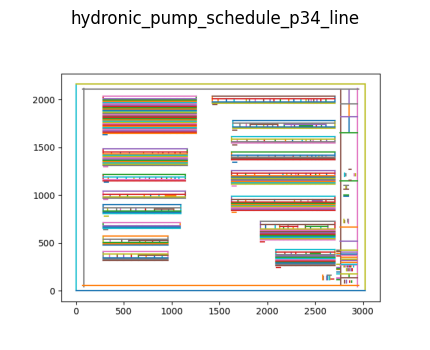

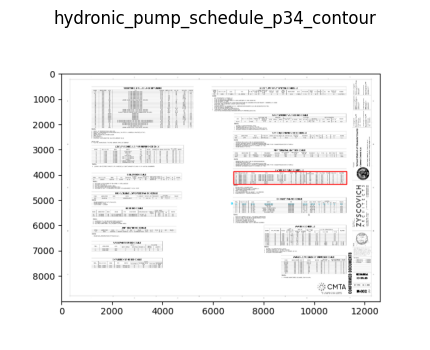

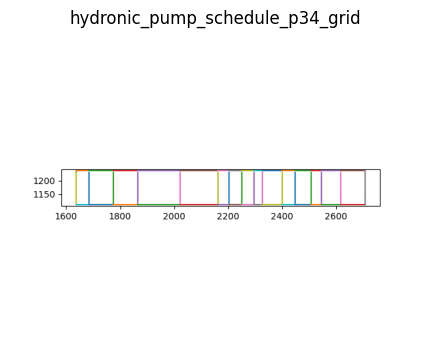

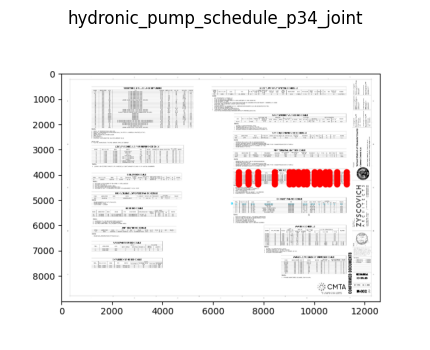

None


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,SYMBOL\nP-1A\nP-1B\nP-1C\nP-2A\nP-2B\nP-3\nP-4,MANUFACTURER\nBELL & GOSSETT\nBELL & GOSSETT\n...,MODEL\ne-1510 3EB\ne-1510 3EB\ne-1510 3EB\ne-1...,TYPE\nBASE MOUNTED CENTRIFUGAL\nBASE MOUNTED C...,SERVICE\nHEAT PUMP LOOP\nHEAT PUMP LOOP\nHEAT ...,GPM\n350\n350\n350\n275\n275\n50\n175,HEAD\n(FT)\n105\n105\n105\n95\n95\n20\n40,VFD\nYES\nYES\nYES\nYES\nYES\nYES\nYES,HP\n20\n20\n20\n10\n10\n0.5\n3,MIN.\nEFFICIENCY(%)\n76.7\n76.7\n76.7\n77.6\n7...,RPM\n1800\n1800\n1800\n1800\n1800\n3600\n1800,VOLTAGE\n460 V\n460 V\n460 V\n460 V\n460 V\n20...,PHASE\n3\n3\n3\n3\n3\n1\n3,FREQUENCY\n60\n60\n60\n60\n60\n60\n60,"REMARKS\n1,2,3,4,5\n1,2,3,4,5\n1,2,3,4,5\n1,2,...",
1,,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,,
4,,,,,,,,,,,,,,,,
5,,,,,,,,,,,,,,,,
6,,,,,,,,,,,,,,,,
7,,,,,,,,,,,,,,,,
8,,,,,,,,,,,,,,,,
9,,,,,,,,,,,,,,,,


In [14]:
i = 0
print(res[i].title)
print(res[i].show_images())
res[i].df

## How well does the combiner combine schedule results?